# Modal analysis of a cooling tower

## Gmsh model

You can find modeling instructions at:
[Creating quadrilateral surface meshes with gmsh](https://bbanerjee.github.io/ParSim/fem/meshing/gmsh/quadrlateral-meshing-with-gmsh/)

![image.png](https://s2.loli.net/2025/03/13/eaPDWJiNug8qvxU.png)

In [47]:
import gmsh
import sys
import math
import json

In [48]:
# Initialize gmsh
gmsh.initialize()

gmsh.model.add("forma11c_gmsh")

``forma11c_profile.json`` can be downloaded from [here](https://biba1632.gitlab.io/code-aster-manuals/docs/validation/v2.08.011.html#geometry-and-mesh)

In [49]:
# Read the profile coordinates
file_id = open("forma11c_profile.json", "r")
coords = json.load(file_id)
file_id.close()

In [50]:
# Set a default element size
el_size = 1.0

# Add profile points
v_profile = []
for coord in coords:
    v = gmsh.model.occ.addPoint(coord[0], coord[1], coord[2], el_size)
    v_profile.append(v)

In [51]:
# Add spline going through profile points
l1 = gmsh.model.occ.addBSpline(v_profile)
# Create copies and rotate
l2 = gmsh.model.occ.copy([(1, l1)])
l3 = gmsh.model.occ.copy([(1, l1)])
l4 = gmsh.model.occ.copy([(1, l1)])

# Rotate the copy
gmsh.model.occ.rotate(l2, 0, 0, 0, 0, 0, 1, math.pi / 2)
gmsh.model.occ.rotate(l3, 0, 0, 0, 0, 0, 1, math.pi)
gmsh.model.occ.rotate(l4, 0, 0, 0, 0, 0, 1, 3 * math.pi / 2)

In [52]:
# Sweep the lines
surf1 = gmsh.model.occ.revolve([(1, l1)], 0, 0, 0, 0, 0, 1, math.pi / 2)
surf2 = gmsh.model.occ.revolve(l2, 0, 0, 0, 0, 0, 1, math.pi / 2)
surf3 = gmsh.model.occ.revolve(l3, 0, 0, 0, 0, 0, 1, math.pi / 2)
surf4 = gmsh.model.occ.revolve(l4, 0, 0, 0, 0, 0, 1, math.pi / 2)

In [53]:
# Join the surfaces
surf5 = gmsh.model.occ.fragment(surf1, surf2)
surf6 = gmsh.model.occ.fragment(surf3, surf4)
surf7 = gmsh.model.occ.fragment(surf5[0], surf6[0])

In [54]:
gmsh.model.occ.remove_all_duplicates()
gmsh.model.occ.synchronize()

In [55]:
num_nodes_circ = 15
for curve in gmsh.model.occ.getEntities(1):
    gmsh.model.mesh.setTransfiniteCurve(curve[1], num_nodes_circ)

In [56]:
num_nodes_vert = 32
vertical_curves = [7, 10, 13, 17]
for curve in vertical_curves:
    gmsh.model.mesh.setTransfiniteCurve(curve, num_nodes_vert)

In [57]:
for surf in gmsh.model.occ.getEntities(2):
    gmsh.model.mesh.setTransfiniteSurface(surf[1])

In [58]:
gmsh.option.setNumber("Mesh.RecombineAll", 1)
gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)
gmsh.option.setNumber("Mesh.Recombine3DLevel", 2)
gmsh.option.setNumber("Mesh.ElementOrder", 1)

In [59]:
# Important:
# Note that we use names to distinguish groups, so please do not overlook this!
# We use the "Boundary" group to include 4 lines
gmsh.model.addPhysicalGroup(dim=1, tags=[6, 9, 12, 15], tag=1, name="Boundary")

1

In [60]:
# Generate mesh
gmsh.model.mesh.generate(dim=2)

In [61]:
gmsh.option.setNumber("Mesh.SaveAll", 1)
gmsh.write("forma11c.msh")

In [62]:
gmsh.fltk.run()

## To OpenSeesPy Model

In [18]:
import openseespy.opensees as ops
import opstool as opst

In [33]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)
E, nu, rho = 2.76e10, 0.166, 2244.0  # Pa, kg/m3
ops.nDMaterial("ElasticIsotropic", 1, E, nu, rho)
secTag = 11
ops.section("PlateFiber", secTag, 1, 0.305)

In [34]:
GMSH2OPS = opst.pre.Gmsh2OPS(ndm=3, ndf=6)

In [35]:
GMSH2OPS.read_gmsh_file("forma11c.msh")

Info:: 1 Physical Names.
Info:: 1821 Nodes; MaxNodeTag 1821; MinNodeTag 1.
Info:: 2009 Elements; MaxEleTag 2009; MinEleTag 1.
Info:: Geometry Information >>>
53 Entities: 37 Point; 12 Curves; 4 Surfaces; 0 Volumes.

Info:: Physical Groups Information >>>
1 Physical Groups.
Physical Group names: ['Boundary']

Info:: Mesh Information >>>
1821 Nodes; MaxNodeTag 1821; MinNodeTag 1.
1972 Elements; MaxEleTag 2009; MinEleTag 38.



In [36]:
# Create OpenSeesPy node commands based on all nodes defined in the GMSH file
node_tags = GMSH2OPS.create_node_cmds()

In [37]:
dim_entity_tags = GMSH2OPS.get_dim_entity_tags()
dim_entity_tags_2D = [item for item in dim_entity_tags if item[0] == 2]

In [38]:
# Create OpenSeesPy element commands for specific entities
ele_tags_n4 = GMSH2OPS.create_element_cmds(
    ops_ele_type="ASDShellQ4",  # OpenSeesPy element type
    ops_ele_args=[
        secTag
    ],  # Additional arguments for the element (e.g., section tag)
    dim_entity_tags=dim_entity_tags_2D,
)

In [39]:
boundary_dim_tags = GMSH2OPS.get_boundary_dim_tags(
    physical_group_names="Boundary", include_self=True)
boundary_dim_tags

[(0, 55), (0, 59), (0, 61), (0, 63), (1, 6), (1, 9), (1, 12), (1, 15)]

In [40]:
fix_ntags = GMSH2OPS.create_fix_cmds(dim_entity_tags=boundary_dim_tags,
                                     dofs=[1] * 6)

In [41]:
removed_node_tags = opst.pre.remove_void_nodes()

Info:: Free nodes with tags [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
25, 26, 27, 28, 29] have been removed!

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

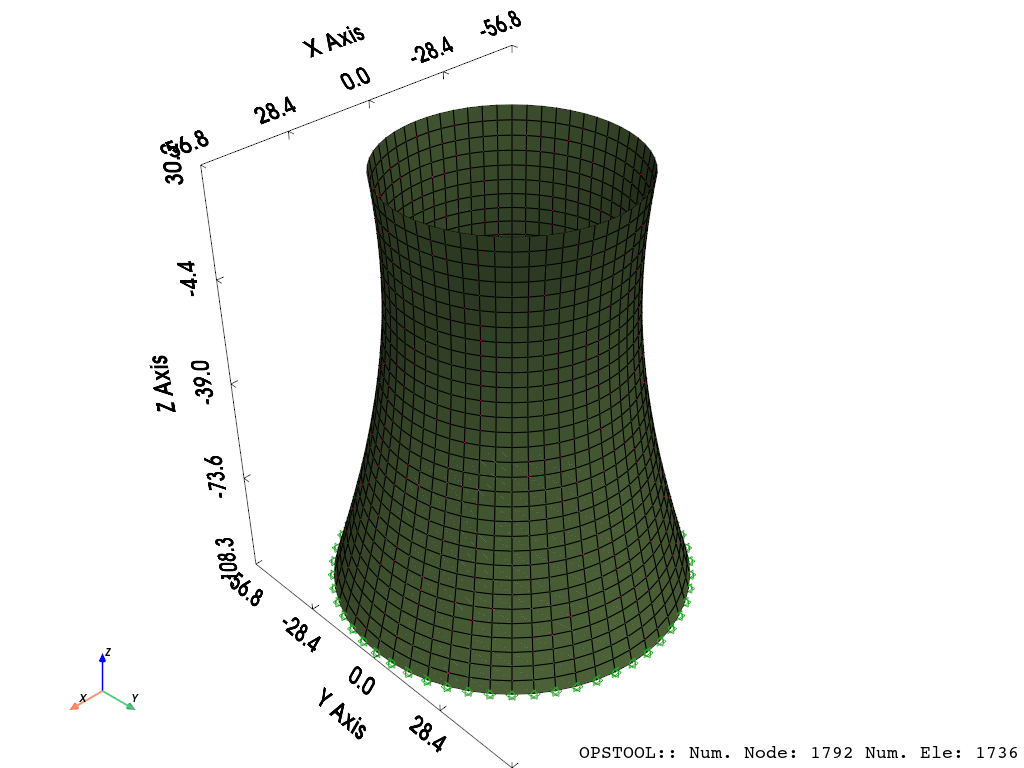

In [42]:
opst.vis.pyvista.set_plot_props(notebook=True)
opst.vis.pyvista.plot_model(show_outline=True).show(
    jupyter_backend="jupyterlab")

In [43]:
opst.post.save_eigen_data(odb_tag="eigen", mode_tag=60)

OPSTOOL ::  Eigen data has been saved to _OPSTOOL_ODB/EigenData-eigen.nc!

OPSTOOL ::  Loading eigen data from _OPSTOOL_ODB/EigenData-eigen.nc ...

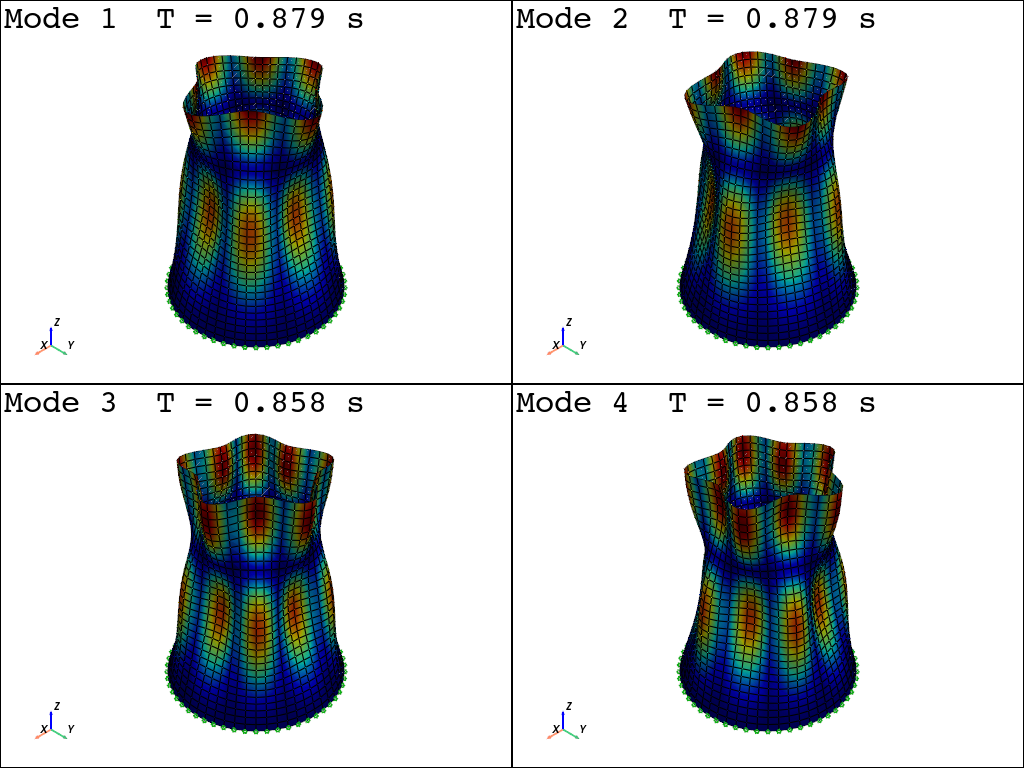

In [44]:
fig = opst.vis.pyvista.plot_eigen(mode_tags=4, odb_tag="eigen", subplots=True)
fig.show(jupyter_backend="jupyterlab")

In [45]:
modal_props, eigen_vectors = opst.post.get_eigen_data(odb_tag="eigen")
modal_props = modal_props.to_pandas()
modal_props.head()

OPSTOOL ::  Loading eigen data from _OPSTOOL_ODB/EigenData-eigen.nc ...

Properties,eigenLambda,eigenOmega,eigenFrequency,eigenPeriod,partiFactorMX,partiFactorMY,partiFactorRMZ,partiFactorMZ,partiFactorRMX,partiFactorRMY,...,partiMassRatiosRMZ,partiMassRatiosMZ,partiMassRatiosRMX,partiMassRatiosRMY,partiMassRatiosCumuMX,partiMassRatiosCumuMY,partiMassRatiosCumuRMZ,partiMassRatiosCumuMZ,partiMassRatiosCumuRMX,partiMassRatiosCumuRMY
modeTags,,,,,,,,,,,,,,,,,,,,,
1,51.13809,7.151090,1.138131,0.878633,-1.725009e-11,9.416032e-11,7.580143e-10,4.230678e-12,1.235457e-09,-2.732507e-09,...,1.305012e-27,7.354305e-29,2.533148e-27,1.239162e-26,1.222656e-27,3.642986e-26,1.305012e-27,7.354305e-29,2.533148e-27,1.239162e-26
2,51.13809,7.151090,1.138131,0.878633,3.297836e-10,-3.389637e-10,7.606061e-10,-1.893008e-11,1.393822e-08,1.180687e-08,...,1.313952e-27,1.472403e-27,3.224185e-25,2.313529e-25,4.480913e-25,5.085234e-25,2.618964e-27,1.545946e-27,3.249516e-25,2.437445e-25
3,53.64215,7.324080,1.165664,0.857880,-3.402908e-10,-9.157581e-12,1.763309e-09,-1.133069e-12,-1.986839e-10,-1.388419e-08,...,7.061824e-27,5.275148e-30,6.551348e-29,3.199237e-25,9.238887e-25,5.088680e-25,9.680788e-27,1.551221e-27,3.250171e-25,5.636682e-25
4,53.64215,7.324080,1.165664,0.857880,4.031667e-10,-1.081433e-10,2.721245e-09,-1.193286e-11,3.973242e-09,1.569658e-08,...,1.681880e-26,5.850744e-28,2.619965e-26,4.088982e-25,1.591757e-24,5.569210e-25,2.649959e-26,2.136296e-27,3.512168e-25,9.725664e-25
5,59.58843,7.719354,1.228573,0.813952,-5.355825e-10,2.271784e-10,-6.861083e-10,5.201697e-12,-1.023211e-08,-2.045787e-08,...,1.069166e-27,1.111762e-28,1.737544e-25,6.945862e-25,2.770379e-24,7.689795e-25,2.756876e-26,2.247472e-27,5.249711e-25,1.667153e-24


In [46]:
modal_props.loc[[1, 47, 48, 60], "eigenFrequency"]

modeTags
1     1.138131
47    2.875771
48    2.875771
60    3.196797
Name: eigenFrequency, dtype: float64

You can compare this with Code-Aster, which uses DKT shell elements.
See ~
[Model C: Modal analysis of a cooling tower¶](https://biba1632.gitlab.io/code-aster-manuals/docs/validation/v2.08.011.html#model-c-modal-analysis-of-a-cooling-tower)

![image.png](https://s2.loli.net/2025/03/13/5G3zqP4JfTOmg2o.png)